# 3. Recurrent Neural Networks with Memory

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.1 (06/02/2022)

**Requirements:**
- Python 3 (tested on v3.9.6)
- Matplotlib (tested on v3.6.2)
- Numpy (tested on v1.23.5)
- Torch (tested on v1.12.1)

### Imports and CUDA

In [1]:
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Torch
import torch
from torch.utils.data import Dataset, DataLoader
# Remove warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Use GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Dataset generation with lag

...

In [3]:
# Generate time series
np.random.seed(27)
datapoints = [round(np.sin(2*np.pi*i/50), 3) for i in range(1000)]

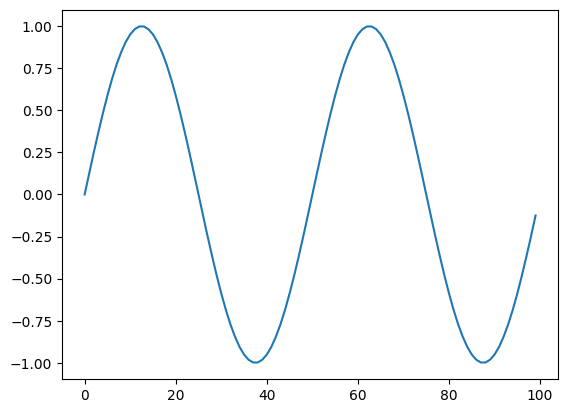

In [4]:
# Show the first 100 points
plt.plot(datapoints[:100])
plt.show()

In [5]:
# Our custom Dataset object
class CustomSeriesDataset(Dataset):
    def __init__(self, datapoints):
        self.datapoints = datapoints
        self.inputs = [datapoints[i] for i in range(len(datapoints) - 1)]
        self.outputs = [datapoints[i + 1] for i in range(len(datapoints) - 1)]
        
    def __len__(self):
        return len(self.outputs)
        
    def __getitem__(self, index):
        inputs = torch.tensor(self.inputs[index]).float()
        outputs = torch.tensor(self.outputs[index]).float()
        return inputs, outputs

In [6]:
# Create dataset and dataloader
dataset = CustomSeriesDataset(datapoints)
dataloader = DataLoader(dataset, batch_size = 1, shuffle = False)

In [7]:
inputs, outputs = dataset[0]
print("Input for sample #0: ", inputs)
print("Output for sample #0: ", outputs)
inputs, outputs = dataset[25]
print("Input for sample  #25: ", inputs)
print("Output for sample  #25: ", outputs)

Input for sample #0:  tensor(0.)
Output for sample #0:  tensor(0.1250)
Input for sample  #25:  tensor(0.)
Output for sample  #25:  tensor(-0.1250)


### Building an autoregressive model with lag

...

In [8]:
class RNN(torch.nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.layers = torch.nn.Sequential(torch.nn.Linear(2, 32),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(32, 8),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(8, 2))
        
    def forward(self, inputs, hidden):
        combined = torch.tensor([inputs, hidden]).to(inputs.device)
        out = self.layers(combined)
        return out

In [9]:
model = RNN().to(device)
print(model.layers)

Sequential(
  (0): Linear(in_features=2, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=8, bias=True)
  (3): ReLU()
  (4): Linear(in_features=8, out_features=2, bias=True)
)


In [10]:
# Fetch a datapoint and try out model prediction
torch.manual_seed(15)
data = next(iter(dataloader))
inputs_test = data[0]
outputs_test = data[1]
hidden = torch.tensor([0])
print("Inputs tensor shape: ", inputs_test.shape)
print("Targets tensor shape: ", outputs_test.shape)
pred = model(inputs_test.to(device), hidden.to(device))
print("Predicted tensor shape: ", pred.shape)

Inputs tensor shape:  torch.Size([1])
Targets tensor shape:  torch.Size([1])
Predicted tensor shape:  torch.Size([2])


### Trainer function

...

In [11]:
def train(model, dataloader, num_epochs, learning_rate, device):
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    hidden = torch.tensor([0]).to(device)
    for epoch in range(num_epochs):
        loss = 0
        optimizer.zero_grad()
        for inputs, targets in dataloader:
            outputs = model(inputs.to(device), hidden)
            out, hidden = outputs[0], outputs[1]
            loss += criterion(out.to(device), targets.to(device))
        loss /= len(dataloader)
        loss.backward()
        optimizer.step()

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}")

In [12]:
# Train the model
model = RNN().to(device)
train(model, dataloader, num_epochs = 100, learning_rate = 0.1, device = device)

Epoch 1/100, Loss: 0.6229
Epoch 2/100, Loss: 0.3301
Epoch 3/100, Loss: 0.1675
Epoch 4/100, Loss: 0.1387
Epoch 5/100, Loss: 0.1081
Epoch 6/100, Loss: 0.1354
Epoch 7/100, Loss: 0.0655
Epoch 8/100, Loss: 0.1487
Epoch 9/100, Loss: 0.0623
Epoch 10/100, Loss: 0.0445
Epoch 11/100, Loss: 0.0718
Epoch 12/100, Loss: 0.0507
Epoch 13/100, Loss: 0.0573
Epoch 14/100, Loss: 0.0709
Epoch 15/100, Loss: 0.0554
Epoch 16/100, Loss: 0.0324
Epoch 17/100, Loss: 0.0331
Epoch 18/100, Loss: 0.0315
Epoch 19/100, Loss: 0.0248
Epoch 20/100, Loss: 0.0416
Epoch 21/100, Loss: 0.0530
Epoch 22/100, Loss: 0.0359
Epoch 23/100, Loss: 0.0126
Epoch 24/100, Loss: 0.0152
Epoch 25/100, Loss: 0.0153
Epoch 26/100, Loss: 0.0104
Epoch 27/100, Loss: 0.0137
Epoch 28/100, Loss: 0.0136
Epoch 29/100, Loss: 0.0069
Epoch 30/100, Loss: 0.0067
Epoch 31/100, Loss: 0.0093
Epoch 32/100, Loss: 0.0065
Epoch 33/100, Loss: 0.0078
Epoch 34/100, Loss: 0.0090
Epoch 35/100, Loss: 0.0054
Epoch 36/100, Loss: 0.0057
Epoch 37/100, Loss: 0.0081
Epoch 38/1

### Test model predictions

...

In [13]:
def test_display(seed, dataloader, model, device):
    # Fetch a datapoint
    hidden = torch.tensor([0]).to(device)
    counter = 0
    for inputs, targets in dataloader:
        outputs = model(inputs.to(device), hidden)
        out, hidden = outputs[0], outputs[1]
        counter += 1
        if(counter == 25):
            # Display
            fig = plt.scatter(24, inputs.cpu().item(), c = "b", marker = "x", label = "Inputs for Sample 25")
            plt.scatter(25, targets.cpu().item(), c = "r", marker = "x", label = "Targets for Sample 25")
            plt.scatter(25, out.cpu().detach().item(), c = "g", marker = "x", \
                        label = "Predictions for Sample 25")
        elif(counter == 30):
            # Display
            fig = plt.scatter(29, inputs.cpu().item(), c = "b", marker = "o", label = "Inputs for Sample 30")
            plt.scatter(30, targets.cpu().item(), c = "r", marker = "o", label = "Targets for Sample 30")
            plt.scatter(30, out.cpu().detach().item(), c = "g", marker = "o", \
                        label = "Predictions for Sample 30")
        elif(counter == 35):
            # Display
            fig = plt.scatter(34, inputs.cpu().item(), c = "b", marker = "P", label = "Inputs for Sample 35")
            plt.scatter(35, targets.cpu().item(), c = "r", marker = "P", label = "Targets for Sample 35")
            plt.scatter(35, out.cpu().detach().item(), c = "g", marker = "P", \
                        label = "Predictions for Sample 35")
    plt.plot(range(24, 36), [round(np.sin(2*np.pi*i/50), 3) for i in range(24, 36)], "k--", \
             label = "Original function used for dataset")
    plt.legend(loc = "best")
    plt.ylim(-1.05, 1.05)
    plt.show()

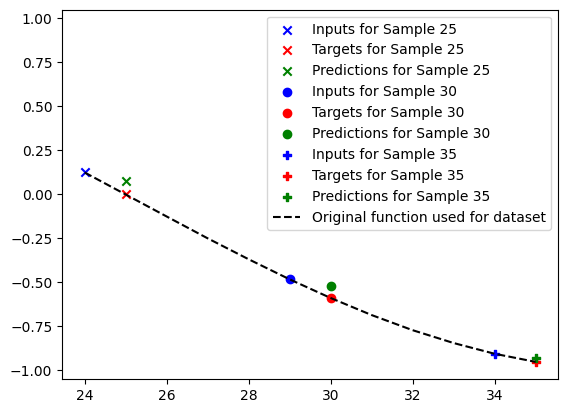

In [14]:
# Try it
test_display(seed = 5, dataloader = dataloader, model = model, device = device)

### What's next?

...